# Find analogues of ERA5 event in Large Ensemble

In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import time
import dask
from dask.distributed import LocalCluster, Client, progress
import matplotlib.pyplot as plt
import os

# my function files
import sys
sys.path.append('/home/portal/script/python/precip_Cristina/')
import functions_visualise_PrMax as fvp
import functions_analogues_LUCAFAMOSS as fan

In [2]:
CERRA_dir = '/work_big/users/portal/CERRA-Land/'
ERA5_dir = '/work_big/users/portal/ERA5/'
fig_dir = '/home/portal/figures/case-studies_byNode/'

### Identify date of ERA5 event

In [3]:
# Event selection
lselect = 'alert-regions'  # 'Italy' or 'wide-region' or 'alert-regions'
no_node = 1
no_event = 1
# Upload the data
if lselect == 'wide-region':
    df_events = pd.read_excel(CERRA_dir+'events_on_wide_regions.xlsx', sheet_name=no_node-1)
elif lselect == 'alert-regions':
    df_events = pd.read_excel(CERRA_dir+'events_cum_on_above99_alert_regions.xlsx', sheet_name=no_node-1)
elif lselect == 'Italy':
    df_events = pd.read_excel(CERRA_dir+'events_on_Italy.xlsx', sheet_name=no_node-1)
time_event = df_events['Time'].iloc[no_event-1] + pd.Timedelta('12h')
doy_event =  time_event.timetuple().tm_yday
# Define lon-lat box of event
box_event = fvp.box_event_PrMax_alertregions(no_node,no_event)

print('Event time:', time_event)
print('Event DOY:', doy_event)
print('Event box:', box_event)

Event time: 2018-10-29 18:00:00
Event DOY: 302
Event box: [-5, 20, 30, 50]


### Upload ERA5 anomaly map of event

In [4]:
def load_ERA5_data(varname, freq, timestep, lonlat_bounds, l_anom):
    """Loads ERA5 data for a given variable, timestep and in lonlat_bounds.
    Timestep can be a single datetime object or a list of datetime objects."""
    # Time variables
    years_data = np.unique(timestep.strftime("%Y"))
    if freq == 'daily':
        timestep = (timestep.normalize() + pd.Timedelta(hours=9)).isoformat()
    # Possible varnames: 'mslp', 'z500'
    data_dir = '/work_big/users/portal/ERA5/'+varname+'/'
    if l_anom:
        files = [os.path.join(data_dir, f'ERA5_{varname}_NH_{freq}_{year}_anom.nc') for year in years_data]
    else:
        files = [os.path.join(data_dir, f'ERA5_{varname}_NH_{freq}_{year}.nc') for year in years_data]
    # Load data
    # select variable and timestep
    if varname == 'z500':
        datasets = [xr.open_dataset(file)['z'].sel(time=timestep, plev=50000) / 9.81 for file in files]
        str_lon, str_lat = ('lon', 'lat')
    elif varname == 'mslp':
        datasets = [xr.open_dataset(file)['msl'].sel(time=timestep) * 0.01 for file in files]
        str_lon, str_lat = ('longitude', 'latitude')
    # concatenate datasets along "time"
    data = xr.concat(datasets, dim="time").squeeze()
    # Define and select lon lat masks
    lon_mask, lat_mask = fvp.lonlat_mask(data[str_lon].values, data[str_lat].values, lonlat_bounds)
    print(lon_mask)
    mask = lat_mask[:, np.newaxis] & lon_mask
    data = data.where(mask, np.nan).dropna(dim=str_lat, how="all").dropna(dim=str_lon, how="all")
    return data

[False False False ... False False False]
[-5.   -4.75 -4.5  -4.25 -4.   -3.75 -3.5  -3.25 -3.   -2.75 -2.5  -2.25
 -2.   -1.75 -1.5  -1.25 -1.   -0.75 -0.5  -0.25  0.    0.25  0.5   0.75
  1.    1.25  1.5   1.75  2.    2.25  2.5   2.75  3.    3.25  3.5   3.75
  4.    4.25  4.5   4.75  5.    5.25  5.5   5.75  6.    6.25  6.5   6.75
  7.    7.25  7.5   7.75  8.    8.25  8.5   8.75  9.    9.25  9.5   9.75
 10.   10.25 10.5  10.75 11.   11.25 11.5  11.75 12.   12.25 12.5  12.75
 13.   13.25 13.5  13.75 14.   14.25 14.5  14.75 15.   15.25 15.5  15.75
 16.   16.25 16.5  16.75 17.   17.25 17.5  17.75 18.   18.25 18.5  18.75
 19.   19.25 19.5  19.75 20.  ]


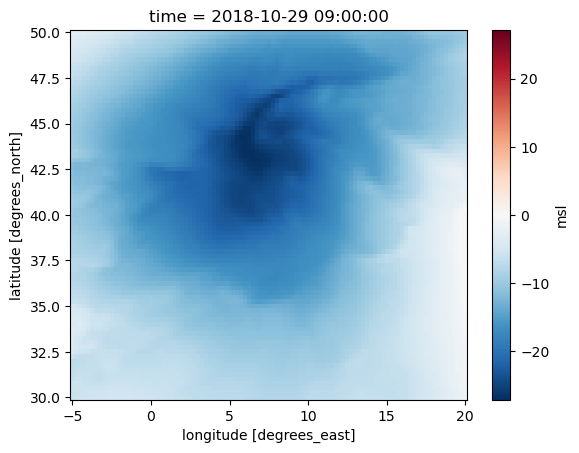

In [6]:
dmslp_event = load_ERA5_data('mslp', 'daily', time_event, box_event, l_anom=True)
mslp_clim = fvp.load_ERA5_clim('mslp', doy_event, box_event, l_smoothing=True)

print(dmslp_event.longitude.values)
dmslp_event.plot()

<>:34: SyntaxWarning: invalid escape sequence '\D'
<>:34: SyntaxWarning: invalid escape sequence '\D'
/tmp/ipykernel_225087/1460406677.py:34: SyntaxWarning: invalid escape sequence '\D'
  cbar = fig.colorbar(cf, ax=ax, shrink=0.6, label="$\Delta$mslp (hPa)")


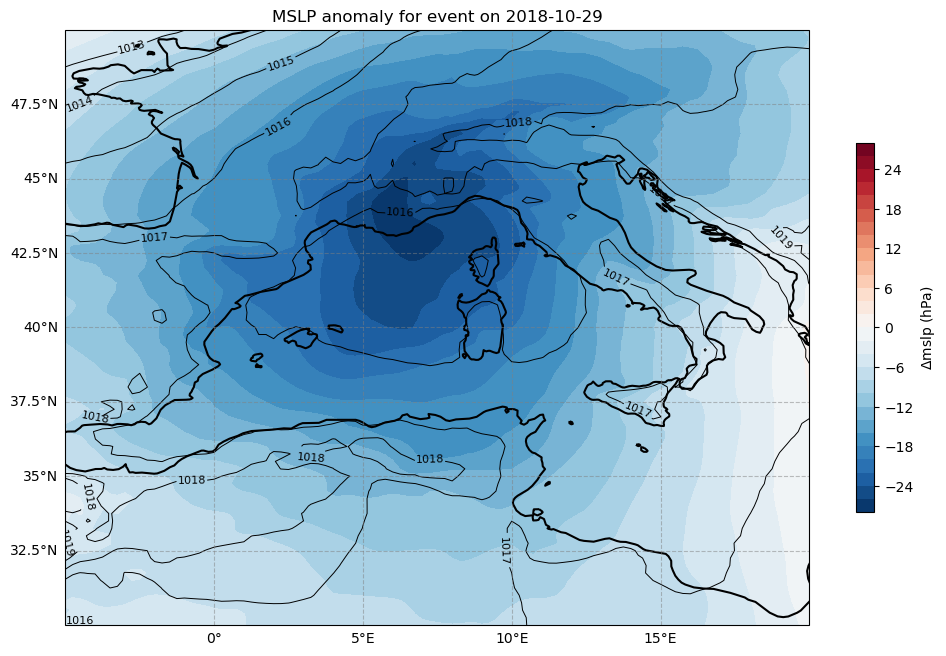

In [6]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Get the lon-lat grid
lon = dmslp_event.longitude
lat = dmslp_event.latitude

# Create a plot with Cartopy
fig, ax = plt.subplots(
    figsize=(12, 8),
    subplot_kw={"projection": ccrs.PlateCarree()}
)

# Calculate the min and max values around zero for centering
vmin = dmslp_event.min().values
vmax = dmslp_event.max().values
cbar_int = 2
cbar_center = max(abs(vmin), abs(vmax)) // cbar_int * cbar_int + cbar_int
cbar_levels = np.arange(-cbar_center, cbar_center+cbar_int, cbar_int)

# Plot data
cf = ax.contourf(lon, lat, dmslp_event, transform=ccrs.PlateCarree(), cmap="RdBu_r", levels= cbar_levels)
contours = ax.contour(lon, lat, mslp_clim, transform=ccrs.PlateCarree(), levels=np.arange(950,1050,1), colors="black", linewidths=0.7)
ax.clabel(contours, inline=True, fontsize=8, fmt="%.0f")

# Add coastlines and gridlines
ax.coastlines(linewidth=1.5)
# Add gridlines
gl = ax.gridlines(draw_labels=True, linestyle="--", color="gray", alpha=0.5)
gl.top_labels = False
gl.right_labels = False

# Add a colorbar
cbar = fig.colorbar(cf, ax=ax, shrink=0.6, label="$\Delta$mslp (hPa)")

plt.title("MSLP anomaly for event on "+str(time_event)[:10])
plt.show()
fig.savefig(fig_dir+'mslp_node'+str(no_node)+'_extreme'+str(no_event)+'-alertregions_box-analogues.png')

In [7]:
varname = 'mslp'
year_range = [2004, 2023]
month_event = time_event.month
months_sel = [month_event-1, month_event, month_event+1]
years_sel = np.arange(year_range[0], year_range[1]+1)
file_pattern = ERA5_dir + varname +"/ERA5_"+varname+"_NH_daily_*_anom.nc"
dmslp_tmp = xr.open_mfdataset(file_pattern, combine='by_coords', parallel=True)['msl'] * 0.01
dmslp_tmp = dmslp_tmp.sel(time=dmslp_tmp.time.dt.month.isin(months_sel))
dmslp_tmp = dmslp_tmp.sel(time=dmslp_tmp.time.dt.year.isin(years_sel))
# Define and select lon lat masks
lon_mask, lat_mask = fvp.lonlat_mask(dmslp_tmp.longitude.values, dmslp_tmp.latitude.values, box_event)
mask = lat_mask[:, np.newaxis] & lon_mask
mask_xr = xr.DataArray(
    mask,
    dims=["latitude", "longitude"],
    coords={"latitude": dmslp_tmp.latitude, "longitude": dmslp_tmp.longitude},
)
dmslp_sel = dmslp_tmp.where(mask_xr, drop=True)

In [8]:
from scipy.spatial.distance import euclidean
import numpy as np
import xarray as xr

def function_distance(X, Y):
    
    """
    INPUT:
    - X[lon,lat]       -> Target pattern
    - Y[time,lon,lat]  -> Dataset in which look for the target pattern
    
    OUTPUT:
    - dist[time]       -> Euclidean distance between the target pattern X and Y
    """
    
    x = X.values.flatten()
    y = Y.values.reshape(Y.shape[0], Y.shape[1] * Y.shape[2])
    
    dist = np.asarray([euclidean(y[time],x) for time in range(y.shape[0])])    
    
    return dist

In [9]:
dist = function_distance(dmslp_event,dmslp_sel)

In [10]:
quantile = 0.99
logdist = np.log(1/dist)
thresh = np.percentile(logdist, quantile*100, axis = 0)
mask_analogues = (logdist >= thresh)
dmslp_analogues = dmslp_sel.isel(time=np.where(mask_analogues)[0])
dmslp_analogues_mean = dmslp_analogues.mean(dim='time').values

/tmp/ipykernel_225087/4017112643.py:2: RuntimeWarning: divide by zero encountered in divide
  logdist = np.log(1/dist)


In [11]:
import calendar
# Get the month names
month_names = [calendar.month_abbr[month] for month in months_sel]
# Extract the initials
str_months = ''.join([name[0] for name in month_names])

<>:19: SyntaxWarning: invalid escape sequence '\D'
<>:19: SyntaxWarning: invalid escape sequence '\D'
/tmp/ipykernel_225087/4149893603.py:19: SyntaxWarning: invalid escape sequence '\D'
  cbar = fig.colorbar(cf, ax=ax, shrink=0.6, label="$\Delta$MSLP (hPa)")


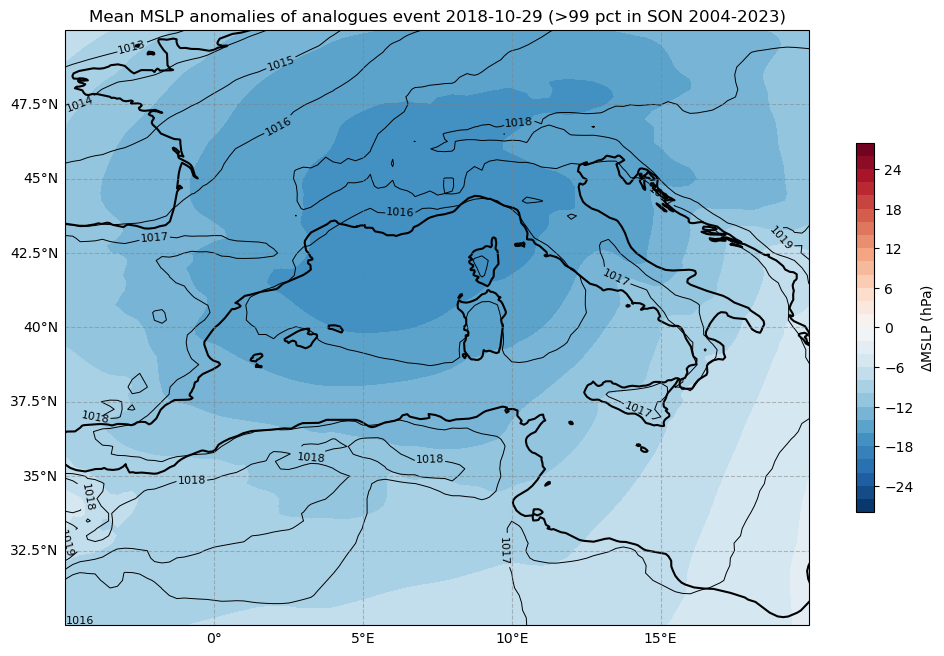

In [ ]:
# Create a plot with Cartopy
fig, ax = plt.subplots(
    figsize=(12, 8),
    subplot_kw={"projection": ccrs.PlateCarree()}
)
# Plot data
cf = ax.contourf(lon, lat, dmslp_analogues_mean, transform=ccrs.PlateCarree(), cmap="RdBu_r", levels= cbar_levels)
contours = ax.contour(lon, lat, mslp_clim, transform=ccrs.PlateCarree(), levels=np.arange(950,1050,1), colors="black", linewidths=0.7)
ax.clabel(contours, inline=True, fontsize=8, fmt="%.0f")

# Add coastlines and gridlines
ax.coastlines(linewidth=1.5)
# Add gridlines
gl = ax.gridlines(draw_labels=True, linestyle="--", color="gray", alpha=0.5)
gl.top_labels = False
gl.right_labels = False

# Add a colorbar
cbar = fig.colorbar(cf, ax=ax, shrink=0.6, label="$\Delta$mslp (hPa)")

plt.title("Mean MSLP anomalies of analogues event "+str(time_event)[:10]+" (>"+str(int(quantile*100))+" pct in "+str_months+' '+str(year_range[0])+'-'+str(year_range[1])+")")
plt.show()
fig.savefig(fig_dir+'analogues-mslp_node'+str(no_node)+'_extreme'+str(no_event)+'-alertregions_mean_'+str(int(quantile*100))+'pct_'+str_months+'_'+str(year_range[0])+'-'+str(year_range[1])+'.png')

### Regrid event anomaly to 0.5 resolution